In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm

In [6]:
def extract_fg(src_path, dst_path):
    # 1. load img
    img = cv2.imread(src_path)
    mask = np.zeros(img.shape[:2],np.uint8)
    
    # 2. create mask img
    t, mask = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), -1, 1,  cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 

    # 2. apply mask pre processing
    ## closing (dilation -> erosion) // if iter, e(e(e(d(d(d(img))))))
    kernel = np.ones((3,3), np.uint8)
    mask_pp = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=10)

    # 3. aggregate mask and img
    fg_img_pp = np.zeros_like(img, dtype=np.uint8)
    
    mask_bg = np.ones_like(mask_pp, dtype=np.uint8) - mask_pp
    
    fg_img_pp = img * mask_pp[:,:,np.newaxis] + \
                    mask_bg[:,:,np.newaxis] * 255
    
    # 3.1 removed img
    removed_img = np.zeros_like(img, dtype=np.uint8)
    removed_img = img * mask_bg[:,:,np.newaxis] + \
                    mask_pp[:,:,np.newaxis] * 0
    
    # 3.2 adjust contrast
    # alpha = 3.0
    # removed_img = np.clip((1+alpha) * removed_img - 128 * alpha, 0, 255).astype(np.uint8)
    
    # 4. show mask diff
    mask_diff = mask_pp - mask
    
    # 5. save new img
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    cv2.imwrite(dst_path, fg_img_pp)
    
    # 6. visual
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 7))
    
    axes[0, 0].imshow(img); axes[0,0].set_title('original')
    axes[0, 1].imshow(fg_img_pp); axes[0,1].set_title('processed')
    axes[0, 2].imshow(removed_img); axes[0,2].set_title('removed')
    
    axes[1, 0].imshow(mask); axes[1,0].set_title('mask')
    axes[1, 1].imshow(mask_pp); axes[1,1].set_title('mask_pp')
    axes[1, 2].imshow(mask_diff); axes[1,2].set_title('mask diff (mask_pp-mask)')
    
    fig.suptitle('Extract FG [{} - {}]'.format(os.path.basename(src_path), mask.shape))
    fig.tight_layout(pad=2)
    plt.show()
    
    # save plt
    os.makedirs(os.path.join(os.path.dirname(dst_path),'plt'), exist_ok=True)
    fig.savefig(os.path.join(os.path.dirname(dst_path),'plt', os.path.basename(dst_path)), dpi=500)

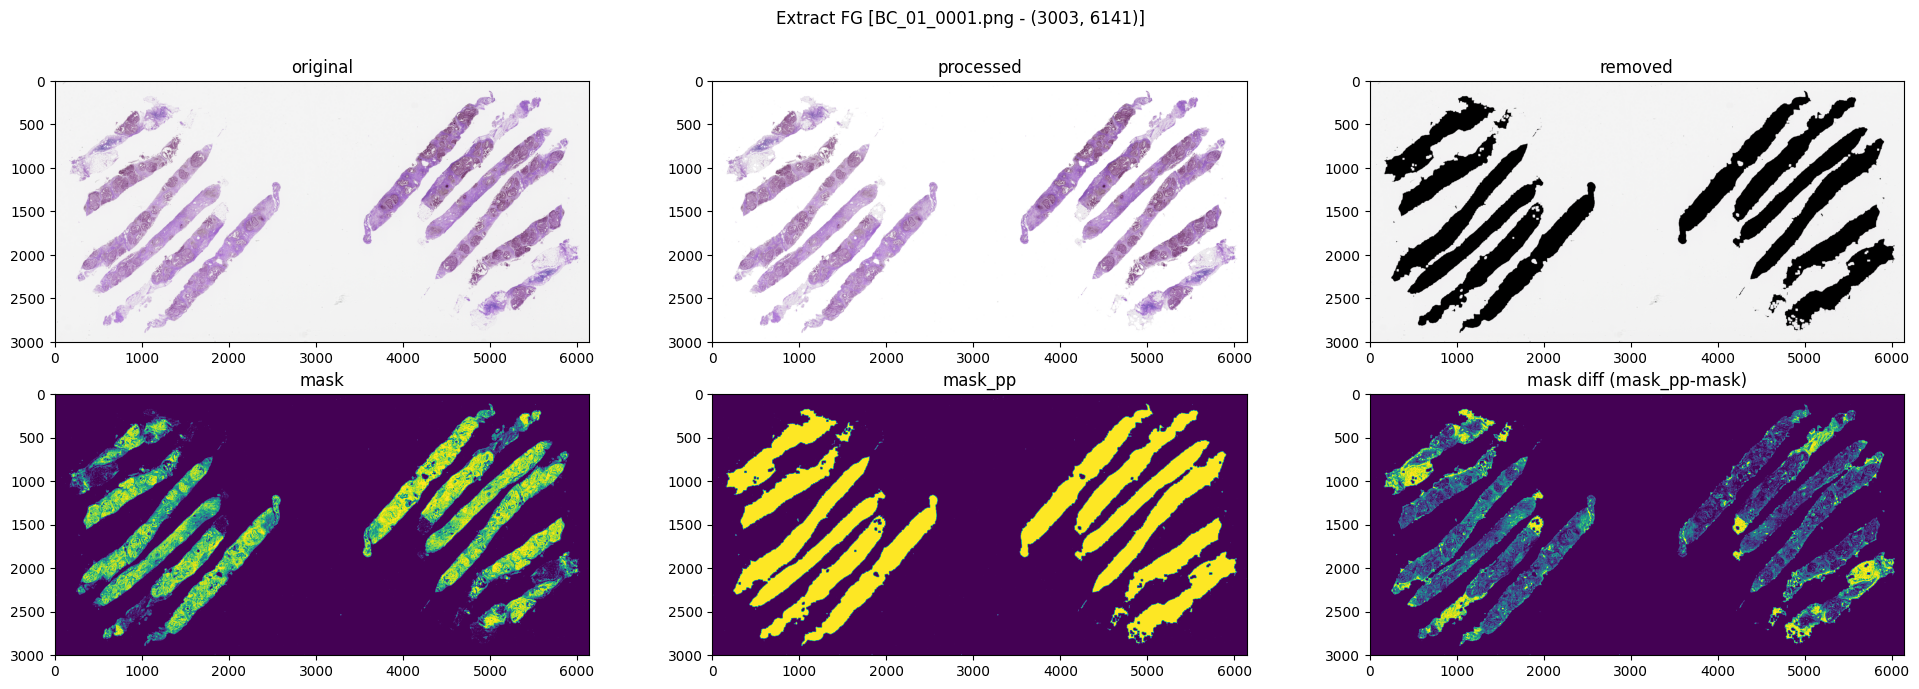

In [7]:
src_dir = '/mnt/d/data_ai/challenge/breast_cancer_metastasis/assets/open/train_imgs'
dst_dir = '/mnt/d/data_ai/challenge/breast_cancer_metastasis/assets/open/train_fg_imgs'

file_list = os.listdir(src_dir)
file_list_img = [file for file in file_list if file.endswith(".png")]

for f_name in file_list_img[:1]:
    src_path = os.path.join(src_dir, f_name)
    dst_path = os.path.join(dst_dir, f_name)
    extract_fg(src_path, dst_path)